In [96]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow.keras as keras
import scipy.stats as stats
import math
from rate import *

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from math import sqrt

from tensorflow.keras.layers import TimeDistributed, Attention, Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, BatchNormalization, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [97]:
def plot_means_variances(y_true, y_means, y_stddevs):
    plt.rc('font', size=14)
    min_vals = np.min([np.min(y_true), np.min(y_means)])
    max_vals = np.max([np.max(y_true), np.max(y_means)])

    plt.figure(figsize=(16, 6))

    # Plot predicted vs true
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_means, alpha = .7, color="0.3", linewidth = 0, s = 2)
    plt.plot([min_vals, max_vals], [min_vals, max_vals], 'k--', color='red')  # Add diagonal line
    plt.title('Fig (a): Predicted vs True Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    
    def plot_binned_residuals(y_true, residuals, num_bins=20):
        bins = np.linspace(min(y_true), max(y_true), num_bins + 1)

        bin_means = [0]*num_bins
        bin_stddevs = [0]*num_bins

        for i in range(num_bins):
            mask = (y_true >= bins[i]) & (y_true < bins[i + 1])
            if np.any(mask):
                bin_means[i] = np.mean(y_true[mask])
                bin_stddevs[i] = np.sqrt(mean_squared_error(y_means[mask], y_true[mask]))
        return bin_means, bin_stddevs

    bin_means, bin_stddevs = plot_binned_residuals(y_true, y_means, num_bins=20)
    
    # Plot residuals vs true
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_stddevs, alpha = .7, color="0.3", linewidth = 0, s = 2, label='Predicted Standard Deviation', zorder=1)
    plt.scatter(bin_means, bin_stddevs, alpha=1, s=50, color='red', label='True Binned Root Mean Squared Error', zorder=2)
    plt.title('Fig (b): Predicted Standard Deviation vs True RMSE')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Standard Deviation')
    plt.legend()


    plt.tight_layout()
    plt.show()

    
def evaluate_and_print_metrics(results, model_name, y_train, y_test, y_train_pred, y_test_pred, y_train_stddevs, y_test_stddevs, ci):
    z_value = stats.norm.ppf((1 + ci) / 2)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)    # in %
    test_mae = mean_absolute_error(y_test, y_test_pred)       # in %

    train_lower_bound = y_train_pred - z_value * y_train_stddevs
    train_upper_bound = y_train_pred + z_value * y_train_stddevs

    test_lower_bound = y_test_pred - z_value * y_test_stddevs
    test_upper_bound = y_test_pred + z_value * y_test_stddevs

    train_within_interval = np.sum(np.logical_and(y_train.ravel() >= train_lower_bound, y_train.ravel() <= train_upper_bound))
    test_within_interval = np.sum(np.logical_and(y_test.ravel() >= test_lower_bound, y_test.ravel() <= test_upper_bound))

    train_percentage_within_interval = (train_within_interval / len(y_train.ravel())) * 100
    test_percentage_within_interval = (test_within_interval / len(y_test.ravel())) * 100

   
    results[model_name] = {
        "Test Root Mean Squared Error (RMSE): ": test_rmse,
        "Test Mean Absolute Error (MAE): ": test_mae,
        f"Percentage of Test Data Points within {ci*100:.2f}% CI: ": test_percentage_within_interval
    }

    print(f"Train RMSE: {train_rmse:.3f}")
    print(f"Test RMSE: {test_rmse:.3f}")
    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f}")
    print(f"Percentage of Train Data Points within {ci*100:.2f}% CI: {train_percentage_within_interval:.2f}%")
    print(f"Percentage of Test Data Points within {ci*100:.2f}% CI: {test_percentage_within_interval:.2f}%")

def plot_confidence_interval_scatter(y_test_pred, y_test_std, y_test, bins=20):
    plt.rc('font', size=14)
    
    # Compute the t-values of the confidence intervals based on Z-scores
    t_values = np.array([stats.norm.ppf(i/bins + (1-i/bins)/2) for i in range(1, bins+1)])

    percentages_within_interval = []
    for t_value in t_values:
        lower_bounds = y_test_pred.ravel() - t_value * y_test_std
        upper_bounds = y_test_pred.ravel() + t_value * y_test_std

        # Count number of data points within the confidence interval
        is_within_interval = np.logical_and(y_test >= lower_bounds, y_test <= upper_bounds)
        num_within_interval = np.sum(is_within_interval)

        # Calculate the percentage of data points within the confidence interval
        percentage_within_interval = (num_within_interval / len(y_test)) * 100
        percentages_within_interval.append(percentage_within_interval)

    plt.figure(figsize=(8, 8))
    plt.scatter(np.arange(1, bins+1), percentages_within_interval, color='blue', label='Percentage within Interval')
    
    # Plot the expected diagonal line (red line)
    plt.plot([0, bins+1], [0, 100], color='red', linestyle='--', label='Expected Diagonal Line')

    plt.xlabel('Confidence Intervals')
    plt.ylabel('Percentage within Interval')
    plt.title('Scatter Plot of Percentage of Data Points within Confidence Intervals')
    plt.legend()

    plt.show()
    
def load_dataset_train_test_split(df, features, output_feature):
    keras.utils.set_random_seed(812)
    X = df[features]
    y = df[output_feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Scale input data to facilitate training
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, np.array(y_train), np.array(y_test), scaler
    
def train_model(model, X_train, y_train, patience, epochs, batch_size, cp_callback):
    tf.random.set_seed(MODELS_SEED)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping, cp_callback])
    return history

def plot_loss_history(history):
    plt.plot(history.history['loss'][1:], label='Training Loss')
    plt.plot(history.history['val_loss'][1:], label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def compute_predictions(model, X_train, X_test, num_samples=100):
    y_train_pred = []
    y_test_pred = []
    for _ in range(num_samples):
        y_train_pred.append(model.predict(X_train))
        y_test_pred.append(model.predict(X_test))
        
    y_train_pred = np.concatenate(y_train_pred, axis=1)
    y_test_pred = np.concatenate(y_test_pred, axis=1)

    y_train_pred_mean = np.mean(y_train_pred, axis=1)
    y_train_pred_stddevs = np.std(y_train_pred, axis=1)
    
    y_test_pred_mean = np.mean(y_test_pred, axis=1)
    y_test_pred_stddevs = np.std(y_test_pred, axis=1)
    
    return y_train_pred_mean, y_train_pred_stddevs, y_test_pred_mean, y_test_pred_stddevs

def NLL(y, distr): 
    return -distr.log_prob(y) 

# We add 0.001 to the standard deviation to ensure it does not converge to 0 and destabilizes training because the gradient
# of maximum likelihood estimation requires the inversion of the variance. We also activate the parameters using a softplus
# activation function to enfore a positive standard deviation estimate.
def normal_softplus(params): 
    return tfd.Normal(loc=params[:, 0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))

def multivariate_covariance_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    return tfd.MultivariateNormalTriL(loc=means, scale_tril=tfp.math.fill_triangular(stds))

def multivariate_diagonal_normal_softplus(mean_params, std_params, d): 
    means = mean_params
    stds = 1e-3 + tf.math.softplus(0.05 * std_params)
    return tfd.MultivariateNormalDiag(loc=means, scale_diag=stds)

def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

def train_multivariate_model(model, X_train, y_train, epochs, batch_size, patience, cp_callback):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    model.build(X_train.shape)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping, cp_callback]
    )

    return history

In [98]:
# In order to ensure that each model has repeatable results,we fix the seed both for the
# data splitting part and for the initilialization of the networks' weights. Theoretially
# speaking, we should average over different seeds to ensure the robustness of our results.
# However, in practice, due to the size of the data set this is unfeasibile and we only do
# this for the best performing model to show that the variability of results based on seed
# is almost none.

keras.utils.set_random_seed(812)
MODELS_SEED = 42

In [99]:
file_path = 'Cleaned_data.pkl'
df_full = pd.read_pickle(file_path)

In [100]:
# Datetime column
DATETIME_COL = 'Date.time'

units = {
'Wind.speed.me': 'm/s',
'Wind.speed.sd': 'm/s', 
'Wind.speed.min': 'm/s',
'Wind.speed.max': 'm/s',
'Front.bearing.temp.me': '°C',
'Front.bearing.temp.sd': '°C',
'Front.bearing.temp.min': '°C',
'Front.bearing.temp.max': '°C',
'Rear.bearing.temp.me': '°C',
'Rear.bearing.temp.sd': '°C',
'Rear.bearing.temp.min': '°C',
'Rear.bearing.temp.max': '°C',
'Rotor.bearing.temp.me': '°C',
'Stator1.temp.me': '°C',
'Nacelle.ambient.temp.me': '°C',
'Nacelle.temp.me': '°C',
'Transformer.temp.me': '°C',
'Gear.oil.temp.me': '°C',
'Gear.oil.inlet.temp.me': '°C',
'Top.box.temp.me': '°C',
'Hub.temp.me': '°C',
'Conv.Amb.temp.me': '°C',
'Rotor.bearing.temp.me': '°C',
'Transformer.cell.temp.me': '°C',
'Motor.axis1.temp.me': '°C',
'Motor.axis2.temp.me': '°C',
'CPU.temp.me': '°C',
'Blade.ang.pitch.pos.A.me': '°',
'Blade.ang.pitch.pos.B.me': '°',
'Blade.ang.pitch.pos.C.me': '°',
'Gear.oil.inlet.press.me': 'bar',
'Gear.oil.pump.press.me': 'bar',
'Drive.train.acceleration.me': 'mm/s^2',
'Tower.Acceleration.x': 'mm/s^2',
'Tower.Acceleration.y': 'mm/s^2'
}

# Features considered
features = [
'Wind.speed.me',
'Wind.speed.sd',
'Wind.speed.min',
'Wind.speed.max',
'Front.bearing.temp.me',
'Front.bearing.temp.sd',
'Front.bearing.temp.min',
'Front.bearing.temp.max',
'Rear.bearing.temp.me',
'Rear.bearing.temp.sd',
'Rear.bearing.temp.min',
'Rear.bearing.temp.max',
'Rotor.bearing.temp.me',
'Stator1.temp.me',
'Nacelle.ambient.temp.me',
'Nacelle.temp.me',
'Transformer.temp.me',
'Gear.oil.temp.me',
'Gear.oil.inlet.temp.me',
'Top.box.temp.me',
'Hub.temp.me',
'Conv.Amb.temp.me',
'Rotor.bearing.temp.me',
'Transformer.cell.temp.me',
'Motor.axis1.temp.me',
'Motor.axis2.temp.me',
'CPU.temp.me',
'Blade.ang.pitch.pos.A.me',
'Blade.ang.pitch.pos.B.me',
'Blade.ang.pitch.pos.C.me',
'Gear.oil.inlet.press.me',
'Gear.oil.pump.press.me',
'Drive.train.acceleration.me',
'Tower.Acceleration.x',
'Tower.Acceleration.y'
]

output_feature = 'Power.me'

In [101]:
# Set confidence interval to be considered as 'normal behaviour'
CONFIDENCE_INTERVAL = 0.99

In [103]:
def flatten_dataframe(df, features, output_feature, date_col):
    df['turbine_id'] = df['turbine']
    df = df.pivot(index=date_col, columns='turbine_id', values=features + [output_feature])
    df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]
    return df

# Only consider the turbine with ID 5
TURBINE_ID = 5

# Specify the number of turbines to consider
turbine_num = 6

# Select the two turbines with the most common non-NaN data points
turbine_counts = df_full.groupby('turbine').apply(lambda x: x.notna().all(axis=1).sum())
turbine_ids = turbine_counts.nlargest(turbine_num).index.tolist()

df_top_n = df_full[df_full['turbine'].isin(turbine_ids)]
df_multivariate = flatten_dataframe(df_top_n, features, output_feature, DATETIME_COL)
df_multivariate.dropna(inplace=True)
df_transfer = df_full[['turbine'] + features + [output_feature] + [DATETIME_COL]]
df_transfer_grouped = df_transfer.groupby(DATETIME_COL)
df_transfer = df_transfer_grouped.filter(lambda group: group.notna().all().all() and len(group) == turbine_num)

# Check the data set is of the same size
assert df_transfer.shape[0] == df_multivariate.shape[0]*turbine_num
df_single_turbine = df_transfer[df_transfer['turbine'] == TURBINE_ID]

In [104]:
print(df_single_turbine.shape)
df_single_turbine.head()

(91326, 38)


,turbine,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,...,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.C.me,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,Power.me,Date.time
778652,5,4.758976,0.470051,3.839334,5.655419,66.905266,0.300394,66.500000,67.350006,65.931580,...,0.0,0.0,0.0,76.154892,329.839172,47.446136,34.605957,12.856477,170.785782,2017-09-25 00:00:00
778653,5,5.053728,0.455439,4.297034,5.879260,66.657501,0.230908,66.300003,67.099998,65.932503,...,0.0,0.0,0.0,78.530861,337.024353,45.788548,24.391794,12.387291,196.361282,2017-09-25 00:10:00
778654,5,4.834767,0.438846,3.727230,5.667759,67.272499,0.084375,67.099998,67.400002,66.452499,...,0.0,0.0,0.0,78.428474,335.595490,44.958530,19.414160,14.047290,213.066101,2017-09-25 00:20:00
778655,5,4.909376,0.403833,3.910666,5.488893,67.349998,0.128452,67.050003,67.550003,66.452499,...,0.0,0.0,0.0,72.759590,318.466614,45.136253,21.682341,11.815598,180.647583,2017-09-25 00:30:00
778656,5,4.800600,0.485835,4.098299,5.829768,67.722504,0.181987,67.400002,68.050003,66.864998,...,0.0,0.0,0.0,73.908447,320.857849,44.799519,21.100346,11.945602,201.553589,2017-09-25 00:40:00


In [105]:
print(df_transfer.shape)
df_transfer.head()

(547956, 38)


,turbine,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,Front.bearing.temp.me,Front.bearing.temp.sd,Front.bearing.temp.min,Front.bearing.temp.max,Rear.bearing.temp.me,...,Blade.ang.pitch.pos.A.me,Blade.ang.pitch.pos.B.me,Blade.ang.pitch.pos.C.me,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,Power.me,Date.time
0,1,5.171129,0.390980,4.240140,5.912565,67.665001,0.194358,67.350006,68.099998,67.337502,...,0.0,0.0,0.0,80.076599,355.346771,44.632309,22.022369,14.627177,200.121521,2017-09-25 00:00:00
1,1,5.090679,0.436131,4.303428,5.930200,67.764999,0.137932,67.500000,68.000000,67.527496,...,0.0,0.0,0.0,79.719238,353.837952,43.258904,20.714163,10.469490,196.931503,2017-09-25 00:10:00
2,1,5.193162,0.305424,4.739578,5.894996,67.639999,0.095655,67.500000,67.800003,67.495003,...,0.0,0.0,0.0,79.778137,353.752502,41.394890,23.446747,11.127916,197.651825,2017-09-25 00:20:00
3,1,4.995740,0.258361,4.488607,5.601314,67.477501,0.104252,67.350006,67.699997,67.467499,...,0.0,0.0,0.0,78.186005,348.852203,43.366161,18.103645,11.582632,182.931046,2017-09-25 00:30:00
4,1,5.111104,0.296016,4.674517,5.677069,67.792496,0.174840,67.500000,68.099998,67.822502,...,0.0,0.0,0.0,79.173264,351.041290,41.450455,19.340059,12.164517,202.370926,2017-09-25 00:40:00


In [106]:
X_train_full, X_test_full, y_train_full, y_test_full, scaler_full = load_dataset_train_test_split(df_transfer, features, output_feature)
X_train_single_turbine, X_test_single_turbine, y_train_single_turbine, y_test_single_turbine, scaler_single_turbine = load_dataset_train_test_split(df_single_turbine, features, output_feature)

In [107]:
# Define the file path for saving the weights
checkpoint_path = '/content/drive/My Drive/Colab Notebooks/initial_model_weights_reduced_data.h5'

# Define the initial model architecture
def generic_model(X_train_full):
    inputs = Input(shape=(X_train_full.shape[1],))
    hidden1 = Dense(300, activation="relu")(inputs)
    hidden2 = Dense(200, activation="relu")(hidden1)
    hidden3 = Dense(100, activation="relu")(hidden2)

    params = Dense(2)(hidden3)

    dist = tfp.layers.DistributionLambda(normal_softplus)(params)

    model = Model(inputs=inputs, outputs=dist)
    model.compile(Adam(learning_rate=0.001), loss=NLL)

    return model

# Train the initial model using X_full with the checkpoint callback
generic_model = generic_model(X_train_full)
generic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37)]              0         
                                                                 
 dense (Dense)               (None, 300)               11400     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

In [108]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = generic_model.fit(X_train_full, y_train_full, epochs=500, batch_size=64,
                            validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/500
6165/6165 [==============================] - 29s 4ms/step - loss: 1475.4855 - val_loss: 5.7685
Epoch 2/500
6165/6165 [==============================] - 27s 4ms/step - loss: 5.2114 - val_loss: 4.9079
Epoch 3/500
6165/6165 [==============================] - 26s 4ms/step - loss: 4.7843 - val_loss: 4.6565
Epoch 4/500
6165/6165 [==============================] - 25s 4ms/step - loss: 4.6350 - val_loss: 4.5187
Epoch 5/500
6165/6165 [==============================] - 27s 4ms/step - loss: 4.5160 - val_loss: 4.4973
Epoch 6/500
6165/6165 [==============================] - 26s 4ms/step - loss: 4.4310 - val_loss: 4.4558
Epoch 7/500
6165/6165 [==============================] - 25s 4ms/step - loss: 4.3704 - val_loss: 4.3697
Epoch 8/500
6165/6165 [==============================] - 26s 4ms/step - loss: 4.3199 - val_loss: 4.3794
Epoch 9/500
6165/6165 [==============================] - 25s 4ms/step - loss: 4.2672 - val_loss: 4.2685
Epoch 10/500
6165/6165 [==============================] - 26s

6165/6165 [==============================] - 24s 4ms/step - loss: 3.8021 - val_loss: 3.8626
Epoch 80/500
6165/6165 [==============================] - 24s 4ms/step - loss: 3.7979 - val_loss: 3.8950
Epoch 81/500
6165/6165 [==============================] - 24s 4ms/step - loss: 3.8026 - val_loss: 3.9099
Epoch 82/500
6165/6165 [==============================] - 26s 4ms/step - loss: 3.7962 - val_loss: 3.8946
Epoch 83/500
6165/6165 [==============================] - 25s 4ms/step - loss: 3.7956 - val_loss: 3.9172
Epoch 84/500
6165/6165 [==============================] - 27s 4ms/step - loss: 3.7951 - val_loss: 3.8833
Epoch 85/500
6165/6165 [==============================] - 29s 5ms/step - loss: 3.7919 - val_loss: 3.9086
Epoch 86/500
6165/6165 [==============================] - 31s 5ms/step - loss: 3.7909 - val_loss: 3.9066
Epoch 87/500
6165/6165 [==============================] - 30s 5ms/step - loss: 3.7878 - val_loss: 3.8979
Epoch 88/500
6165/6165 [==============================] - 30s 5ms/st

In [109]:
# Step 3: Load the weights of the initial model
generic_model.load_weights(checkpoint_path)
evaluation = generic_model.evaluate(X_test_full, y_test_full)
print("Evaluation Loss:", evaluation)

3425/3425 [==============================] - 7s 2ms/step - loss: 3.8865
Evaluation Loss: 3.886470317840576


In [110]:
hidden_layer = generic_model.layers[-2].output

In [111]:
def create_model_finetune(X_train, generic_model, seed):
    keras.utils.set_random_seed(seed)

    inputs = Input(shape=(X_train.shape[1],))

    # Step 1: Load the architecture and weights of the previously trained model
    pretrained_model_layers = generic_model.layers[1:-2]
    x = inputs

    for layer in pretrained_model_layers:
        layer.trainable = False
        x = layer(x)

    hidden1 = Dense(100, activation="relu")(x)
    hidden2 = Dense(80, activation="relu")(hidden1)
    hidden3 = Dense(40, activation="relu")(hidden2)

    mean_h1 = Dense(20, activation="relu")(hidden3)
    mean_h2 = Dense(10, activation="relu")(mean_h1)
    mean_out = Dense(1)(mean_h2)

    variance_h1 = Dense(20, activation="relu")(hidden3)
    variance_h2 = Dense(10, activation="relu")(variance_h1)
    variance_out = Dense(1)(variance_h2)

    params = Concatenate()([mean_out, variance_out])


    dist = tfp.layers.DistributionLambda(normal_softplus)(params)

    model_mlp_gaussian = Model(inputs=inputs, outputs=dist)
    model_mlp_gaussian.compile(Adam(learning_rate=0.001), loss=NLL)

    return model_mlp_gaussian

model_finetune = create_model_finetune(X_train_single_turbine, generic_model, MODELS_SEED)
model_finetune.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 37)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 300)                  11400     ['input_2[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 200)                  60200     ['dense[1][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 100)                  20100     ['dense_1[1][0]']             
                                                                                            

Epoch 1/200
2055/2055 [==============================] - 11s 4ms/step - loss: 83.2328 - val_loss: 4.0898
Epoch 2/200
2055/2055 [==============================] - 8s 4ms/step - loss: 4.0205 - val_loss: 3.9738
Epoch 3/200
2055/2055 [==============================] - 7s 4ms/step - loss: 4.0004 - val_loss: 3.9561
Epoch 4/200
2055/2055 [==============================] - 9s 4ms/step - loss: 3.9922 - val_loss: 3.9411
Epoch 5/200
2055/2055 [==============================] - 8s 4ms/step - loss: 3.9736 - val_loss: 4.0019
Epoch 6/200
2055/2055 [==============================] - 8s 4ms/step - loss: 3.9726 - val_loss: 4.0168
Epoch 7/200
2055/2055 [==============================] - 8s 4ms/step - loss: 3.9714 - val_loss: 3.9125
Epoch 8/200
2055/2055 [==============================] - 8s 4ms/step - loss: 3.9801 - val_loss: 3.9189
Epoch 9/200
2055/2055 [==============================] - 7s 3ms/step - loss: 3.9792 - val_loss: 3.9274
Epoch 10/200
2055/2055 [==============================] - 7s 4ms/step -

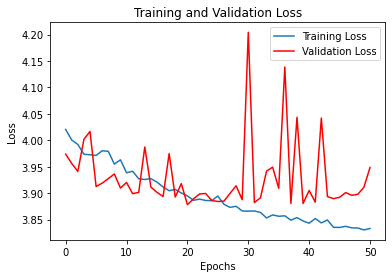

In [112]:
# Define the callback to save the weights
checkpoint_callback = ModelCheckpoint(filepath='saved_models/finetuned_reduced_data.keras', save_weights_only=True,
                                      monitor='val_loss', mode='min', save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model_finetune.fit(X_train_single_turbine, y_train_single_turbine, epochs=200, batch_size=32,
                            validation_split=0.1, callbacks=[checkpoint_callback, early_stopping_callback])
plot_loss_history(history)

In [ ]:
y_train_pred = np.array(model_finetune(X_train_single_turbine).mean()).ravel()
y_test_pred = np.array(model_finetune(X_test_single_turbine).mean()).ravel()

y_train_stddevs = np.array(model_finetune(X_train_single_turbine).stddev()).ravel()
y_test_stddevs = np.array(model_finetune(X_test_single_turbine).stddev()).ravel()

evaluate_and_print_metrics({}, f"Fine Tuned",
y_train_single_turbine, y_test_single_turbine, y_train_pred, y_test_pred,
y_train_stddevs, y_test_stddevs, 0.99)

plot_means_variances(y_test_single_turbine, y_test_pred, y_test_stddevs)
plot_confidence_interval_histogram(y_test_pred, y_test_stddevs, y_test_single_turbine, bins=20)